# Pendahuluan

Pada notebook ini akan dilakukan analisis terhadap performa Real Madrid di La Liga untuk musim 2008/2009 hingga 2015/2016. Data yang digunakan adalah data European Soccer Database dari kaggle (https://www.kaggle.com/datasets/hugomathien/soccer). Notebook ini hanya digunakan sebagai portofolio saya dan sarana latihan bagi saya. Oleh karena itu notebook ini bukan digunakan untuk kepentingan komersil.

In [1]:
# Import modul yang diperlukan
import numpy as np
import pandas as pd
import sqlite3 #modul untuk mengakses database sqlite
import matplotlib.pyplot as plt
import seaborn as sns
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [2]:
# koneksi dengan database sqlite
conn = sqlite3.connect("\path\database.sqlite")

In [3]:
#Rician database European Soccer Database
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
# query sql
Hasil_RM_raw = pd.read_sql(
    """Select season, date, t1.team_long_name home_team, t2.team_long_name away_team, home_team_goal, away_team_goal,
case 
when t1.team_long_name = 'Real Madrid CF' then 'Kandang'
when m.away_team_api_id = 8633 then 'Tandang' end as posisi,
case 
when t1.team_long_name = 'Real Madrid CF' then home_team_goal
when m.away_team_api_id = 8633 then away_team_goal end as goal_RM,
case 
when t1.team_long_name = 'Real Madrid CF' then away_team_goal
when m.away_team_api_id = 8633 then home_team_goal end as goal_lawan,
case 
when t1.team_long_name = 'Real Madrid CF' and home_team_goal > away_team_goal then 'Menang'
when t1.team_long_name = 'Real Madrid CF' and home_team_goal < away_team_goal then 'Kalah'
when m.away_team_api_id = 8633 and home_team_goal < away_team_goal then 'Menang'
when m.away_team_api_id = 8633 and home_team_goal > away_team_goal then 'Kalah'
else 'Seri' end as Hasil_RM
from Match m 
left join Team t1 on m.home_team_api_id = t1.team_api_id
left join Team t2 on m.away_team_api_id = t2.team_api_id
where country_id = 21518 and posisi is not null
order by date;""", conn,parse_dates=['date']) #Mengambil data setiap pertandingan La Liga Real Madrid pada rentang tahun 2008-2015

Hasil_RM_raw.head()

,season,date,home_team,away_team,home_team_goal,away_team_goal,posisi,goal_RM,goal_lawan,Hasil_RM
0,2008/2009,2008-08-31,RC Deportivo de La Coruña,Real Madrid CF,2,1,Tandang,1,2,Kalah
1,2008/2009,2008-09-14,Real Madrid CF,CD Numancia,4,3,Kandang,4,3,Menang
2,2008/2009,2008-09-21,Racing Santander,Real Madrid CF,0,2,Tandang,2,0,Menang
3,2008/2009,2008-09-24,Real Madrid CF,Real Sporting de Gijón,7,1,Kandang,7,1,Menang
4,2008/2009,2008-09-27,Real Betis Balompié,Real Madrid CF,1,2,Tandang,2,1,Menang


In [5]:
Hasil_RM_raw.shape

(304, 10)

Data ini memiliki 304 baris (records) dan memiliki 10 kolom. Adapun penjelasan tiap kolom adalah sebagai berikut:
1. season: Menunjukkan season dari suatu pertandingan
2. date: Menunjukkan tanggal dilaksanakannya pertandingan
3. home_team: Menunjukkan tim yang berperan sebagai tuan rumah
4. away_team: Menunjukkan tim yang berperan sebagai tim tamu
5. home_team_goal: Jumlah gol yang dicetak oleh tim tuan rumah
6. away_team_goal: Jumlah gol yang dicetak oleh tim tamu
7. posisi: Posisi dari Real Madrid pada suatu pertandinga (tuan rumah atau tim tamu)
8. goal_RM: Jumlah gol yang dicetak oleh Real Madrid pada suatu pertandingan
9. goal_lawan: Jumlah gol kemasukan Real Madrid pada suatu pertandingan
10. Hasil_RM: Hasil pertandingan yang didapati oleh Real Madrid

In [6]:
Hasil_RM_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   season          304 non-null    object        
 1   date            304 non-null    datetime64[ns]
 2   home_team       304 non-null    object        
 3   away_team       304 non-null    object        
 4   home_team_goal  304 non-null    int64         
 5   away_team_goal  304 non-null    int64         
 6   posisi          304 non-null    object        
 7   goal_RM         304 non-null    int64         
 8   goal_lawan      304 non-null    int64         
 9   Hasil_RM        304 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 23.9+ KB


Dapat terlihat dari info tersebut bahwa setiap kolom memiliki 304 non null records, sehingga dataset ini tidak memiliki *missing value*

In [7]:
Hasil_RM_raw.duplicated().sum()

0

Dataset ini juga tidak memiliki data yang duplikat

In [8]:
Hasil_RM_raw.describe()

,home_team_goal,away_team_goal,goal_RM,goal_lawan
count,304.000000,304.000000,304.000000,304.000000
mean,2.177632,1.595395,2.773026,1.000000
std,1.879548,1.516938,1.832363,1.034073
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,2.000000,1.000000,3.000000,1.000000
75%,3.000000,2.000000,4.000000,2.000000
max,10.000000,8.000000,10.000000,6.000000


Tabel di atas menunjukkan sekilas mengenai statistik deskriptif dari dataset. Ada beberapa hal yang dapat dipelajari:

1. Real Madrid rata-rata memasukan sebanyak 2 hingga 3 gol per pertandingannya, gol terbanyak yang pernah Real Madrid cetak dalam satu pertandingan adalah 10 gol
2. Real Madrid rata-rata hanya kemasukan 1 gol tiap pertandingannya, gol kemasukan terbanyak yang pernah Real Madrid alami dalam satu pertandingan adalah 6 gol
3. Secara sekilas dapat terlihat bahwa rata-rata gol memasukan Real Madrid lebih tinggi daripada gol kemasukannya. Hal ini dapat menjadi indikasi awal bahwa Real Madrid lebih sering menang daripada seri atau kalah, tetapi hal ini perlu diperiksa lebih lanjut lagi.

([<matplotlib.patches.Wedge at 0x1f833b2a280>,
 [Text(1.0073506527883973, 0.4418649820101046, 'Kalah'),
  Text(-1.0990603328820194, -0.04545750416889047, 'Menang'),
  Text(1.024750212126957, -0.39985872848514487, 'Seri')],
 [Text(0.5494639924300347, 0.2410172629146025, '13.16%'),
  Text(-0.5994874542992833, -0.024795002273940252, '75.00%'),
  Text(0.5589546611601582, -0.21810476099189718, '11.84%')])

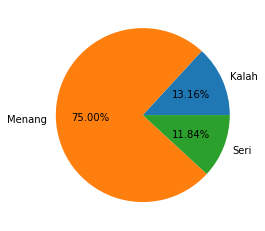

In [9]:
pie_hasil = Hasil_RM_raw.groupby('Hasil_RM')['date'].count().reset_index()
plt.pie(pie_hasil['date'],labels=pie_hasil['Hasil_RM'], autopct='%1.2f%%')

Diagram pie tersebut mengkonfirmasi tebakan awal bahwa Real Madrid lebih sering menang. Selama 8 musim, Real Madrid memenangkan 75% pertandingan yang dilakoninya dan kalah 13,16% serta seri sebanyak 11,84%.

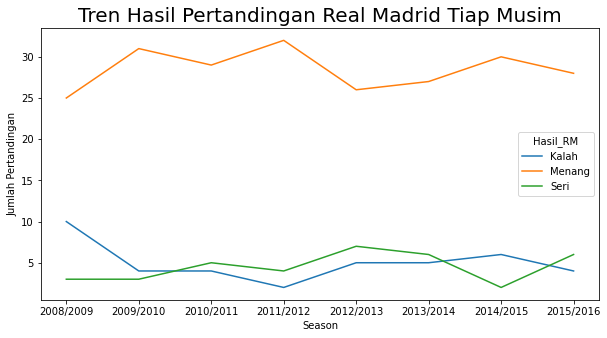

In [10]:
tren_musim = Hasil_RM_raw.groupby(['season','Hasil_RM'])['date'].count().unstack()
tren_musim.plot()
plt.title('Tren Hasil Pertandingan Real Madrid Tiap Musim', fontsize=20)
plt.xlabel('Season')
plt.ylabel('Jumlah Pertandingan')
plt.gcf().set_size_inches(10, 5)

Berdasarkan tren hasil tersebut terlihat bahwa tiap musimnya Real Madrid akan mendapatkan hasil kemenangan > 25 kali. Terjadi peningkatan signifikan terhadap performa Real Madrid pada musim 2009/2010 dari musim sebelumnya. Hal ini ditunjukkan oleh peningkatan jumlah kemenangan dan penurunan jumlah kekalahan. Salah satu faktor utama nya adalah pada musim tersebut Real Madrid melakukan transfer pemain dalam jumlah yang banyak.

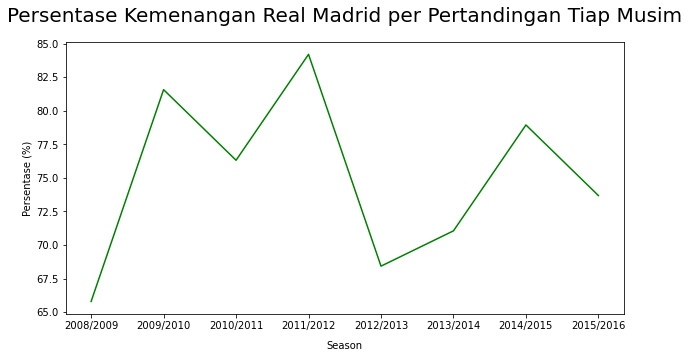

In [11]:
plt.plot(tren_musim['Menang']/38*100, color='green')
plt.title('Persentase Kemenangan Real Madrid per Pertandingan Tiap Musim', fontsize=20, pad=20)
plt.xlabel('Season', labelpad=10)
plt.ylabel('Persentase (%)')
plt.gcf().set_size_inches(10, 5)

Presentase kemenangan diperoleh Real Madrid pada musim 2011/2012 dengan 84%. Pada musim tersebut Real Madrid meraih gelar La Liga

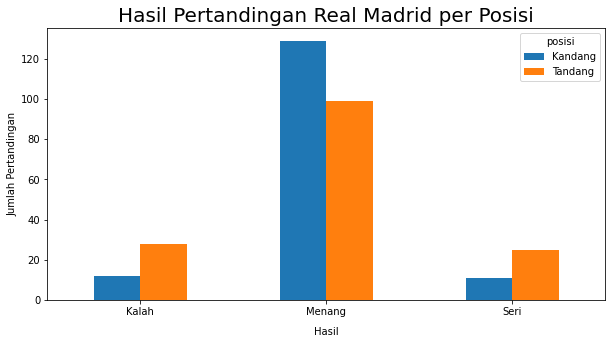

In [12]:
tren_posisi = Hasil_RM_raw.groupby(['Hasil_RM','posisi'])['date'].count().unstack()
tren_posisi.plot(kind='bar')
plt.title('Hasil Pertandingan Real Madrid per Posisi', fontsize=20)
plt.xlabel('Hasil', labelpad=10)
plt.ylabel('Jumlah Pertandingan')
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10, 5)

Berdasarkan grafik tersebut jelas terlihat bahwa posisi Real Madrid mempengaruhi hasil yang diperoleh. Umumnya Real Madrid lebih sering menang saat bermain di Kandang, sedangkan saat sedang bermain tandang jumlah hasil tidak menang (seri atau kalah) meningkat.

In [13]:
def lawan(df):
    if df['posisi'] == 'Kandang':
        val = df['away_team']
    else:
        val = df['home_team']
    return val

In [14]:
Hasil_RM_raw['lawan'] = Hasil_RM_raw.apply(lawan,axis=1)

In [15]:
Hasil_RM_raw

,season,date,home_team,away_team,home_team_goal,away_team_goal,posisi,goal_RM,goal_lawan,Hasil_RM,lawan
0,2008/2009,2008-08-31,RC Deportivo de La Coruña,Real Madrid CF,2,1,Tandang,1,2,Kalah,RC Deportivo de La Coruña
1,2008/2009,2008-09-14,Real Madrid CF,CD Numancia,4,3,Kandang,4,3,Menang,CD Numancia
2,2008/2009,2008-09-21,Racing Santander,Real Madrid CF,0,2,Tandang,2,0,Menang,Racing Santander
3,2008/2009,2008-09-24,Real Madrid CF,Real Sporting de Gijón,7,1,Kandang,7,1,Menang,Real Sporting de Gijón
4,2008/2009,2008-09-27,Real Betis Balompié,Real Madrid CF,1,2,Tandang,2,1,Menang,Real Betis Balompié
...,...,...,...,...,...,...,...,...,...,...,...
299,2015/2016,2016-04-20,Real Madrid CF,Villarreal CF,3,0,Kandang,3,0,Menang,Villarreal CF
300,2015/2016,2016-04-23,Rayo Vallecano,Real Madrid CF,2,3,Tandang,3,2,Menang,Rayo Vallecano
301,2015/2016,2016-04-30,Real Sociedad,Real Madrid CF,0,1,Tandang,1,0,Menang,Real Sociedad
302,2015/2016,2016-05-08,Real Madrid CF,Valencia CF,3,2,Kandang,3,2,Menang,Valencia CF


In [16]:
tren_lawan = Hasil_RM_raw.groupby(['lawan','Hasil_RM'])['date'].count().unstack().fillna(0).reset_index()
tren_lawan

Hasil_RM,lawan,Kalah,Menang,Seri
0,Athletic Club de Bilbao,2.0,13.0,1.0
1,Atlético Madrid,4.0,9.0,3.0
2,CA Osasuna,2.0,7.0,3.0
3,CD Numancia,0.0,2.0,0.0
4,CD Tenerife,0.0,2.0,0.0
5,Córdoba CF,0.0,2.0,0.0
6,Elche CF,0.0,4.0,0.0
7,FC Barcelona,10.0,4.0,2.0
8,Getafe CF,2.0,14.0,0.0
9,Granada CF,1.0,9.0,0.0


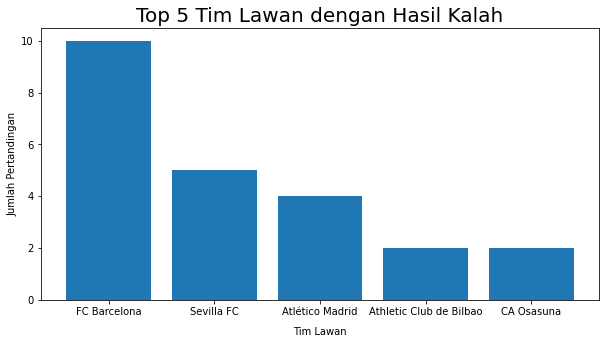

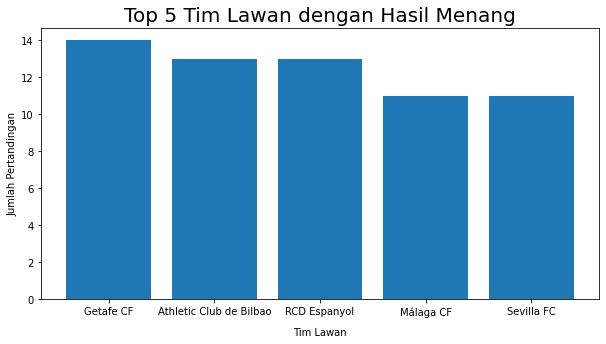

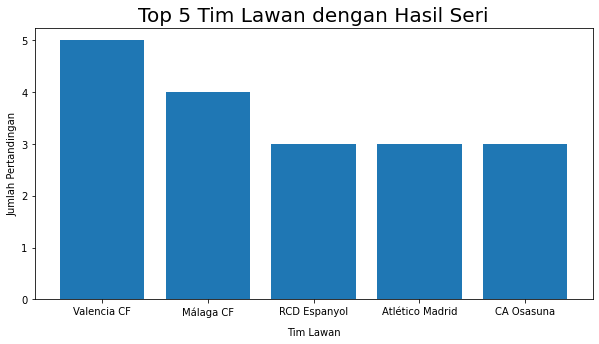

In [17]:
for hasil in Hasil_RM_raw['Hasil_RM'].unique():
    tren_pie = tren_lawan.sort_values([hasil],ascending=False).head(5)
    plt.bar(height=tren_pie[hasil],x=tren_pie['lawan'])
    plt.gcf().set_size_inches(10, 5)
    plt.xlabel('Tim Lawan', labelpad=10)
    plt.ylabel('Jumlah Pertandingan')
    plt.title(f'Top 5 Tim Lawan dengan Hasil {hasil}', fontsize=20)
    plt.show()

Masing-masing tabel menunjukkan top 5 tim lawan dengan hasil tertentu. Sebagai contoh, Real Madrid paling sering kalah saat melawan Barcelona dengan total kekalahan 10 kali sedangkan Real Madrid paling sering menang melawan Getafe dengan 14x kemenangan.

In [18]:
Hasil_RM_raw['goal_diff'] = Hasil_RM_raw['goal_RM'] - Hasil_RM_raw['goal_lawan']

C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='goal_diff'>

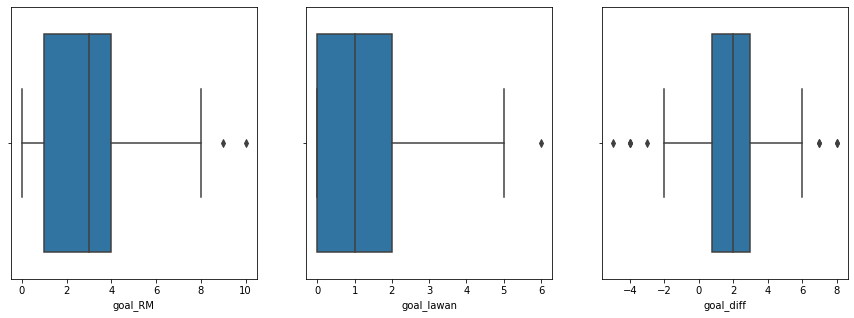

In [19]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(Hasil_RM_raw['goal_RM'], ax=axes[0])
sns.boxplot(Hasil_RM_raw['goal_lawan'], ax=axes[1])
sns.boxplot(Hasil_RM_raw['goal_diff'], ax=axes[2])

Dari boxplot tersebut dapat diperoleh beberapa informasi yaitu:
1. Goal Memasukan: Real Madrid memiliki median gol memasukan sekitar 3 gol per laga nya, kemudian umumnya Real Madrid dapat memasukan 1 hingga 4 gol per laga nya
2. Goal Kemasukan: Real Madrid memiliki median gol kemasukan sekitar 1 gol per laga nya, kemudian umumnya Real Madrid dapat kemasukan 0 hingga 2 gol per laga nya
3. Selisih Goal: selisih gol Real Madrid memiliki median 2 gol per laganya dengan umumnya selisih gol antara 1 hingga 3 gol per laga nya.

In [20]:
trend_goal = Hasil_RM_raw.groupby('season')[['goal_RM','goal_lawan','goal_diff']].sum().reset_index()
trend_goal

,season,goal_RM,goal_lawan,goal_diff
0,2008/2009,83,52,31
1,2009/2010,102,35,67
2,2010/2011,102,33,69
3,2011/2012,121,32,89
4,2012/2013,103,42,61
5,2013/2014,104,38,66
6,2014/2015,118,38,80
7,2015/2016,110,34,76


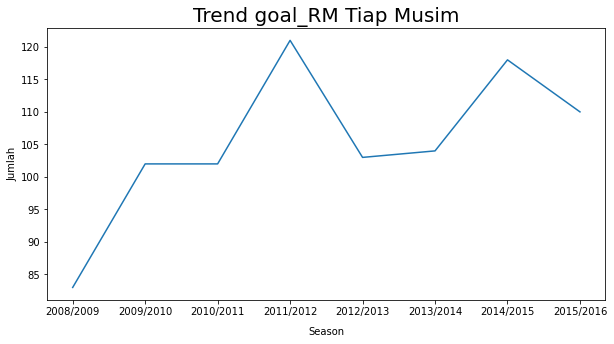

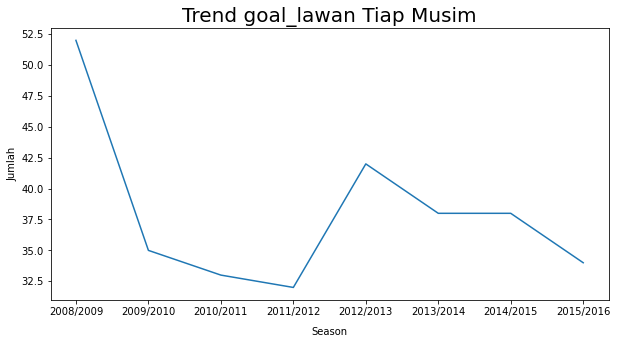

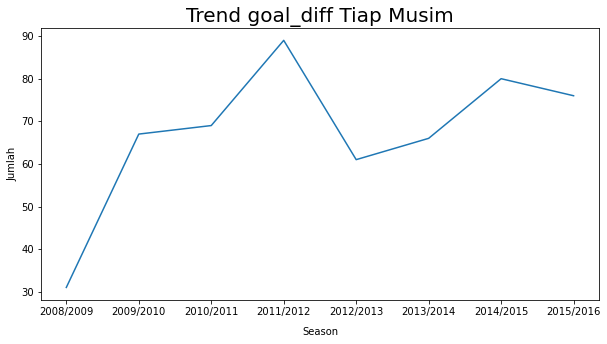

In [21]:
for gol in ['goal_RM','goal_lawan','goal_diff']:
    plt.plot(trend_goal['season'],trend_goal[gol])
    plt.gcf().set_size_inches(10, 5)
    plt.xlabel('Season', labelpad=10)
    plt.ylabel('Jumlah')
    plt.title(f'Trend {gol} Tiap Musim', fontsize=20)
    plt.show()

Dari plot tersebut kembali terlihat bahwa pembelian pemain dalam jumlah yang signifikan pada musim 2009/2010 memberikan dampak yang signifikan pula. Terlihat terjadi kenaikan jumlah gol memasukan yang signifikan pada musim tersebut dibandingkan musim sebelumnya. Selain itu, sejak musim 2009/2010 juga Real Madrid selalu mencetak gol > 100 gol permusimnya. Pola peningkatan performa yang sama juga terlihat pada jumlah gol kemasukan Real Madrid yang mengalami penurunan drastis pada musim 2009/2010.

In [29]:
perform_posisi = Hasil_RM_raw.groupby('posisi')[['goal_RM','goal_lawan']].sum()

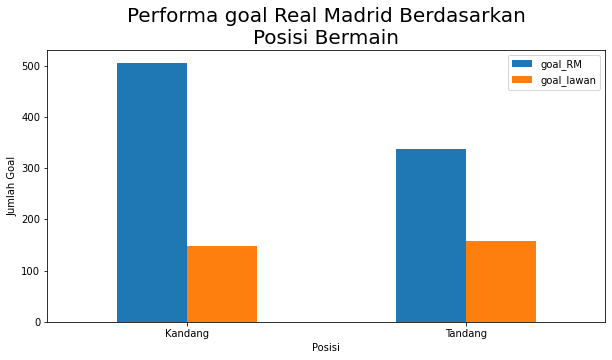

In [30]:
perform_posisi.plot(kind='bar')
plt.title('Performa goal Real Madrid Berdasarkan\nPosisi Bermain', fontsize=20)
plt.xlabel('Posisi',)
plt.ylabel('Jumlah Goal')
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10, 5)

Faktor posisi juga kembali terlihat berdampak pada perfomra gol Real Madrid. Real Madrid lebih sering memasukan gol saat bermain kandang ketimbang tandang. Selain itu jumlah gol kemasukan juga lebih sedikit saat bermain kandang ketimbang tandang.

In [24]:
Hasil_RM_raw['bulan'] = Hasil_RM_raw['date'].dt.month

In [25]:
Hasil_RM_raw.head()

,season,date,home_team,away_team,home_team_goal,away_team_goal,posisi,goal_RM,goal_lawan,Hasil_RM,lawan,goal_diff,bulan
0,2008/2009,2008-08-31,RC Deportivo de La Coruña,Real Madrid CF,2,1,Tandang,1,2,Kalah,RC Deportivo de La Coruña,-1,8
1,2008/2009,2008-09-14,Real Madrid CF,CD Numancia,4,3,Kandang,4,3,Menang,CD Numancia,1,9
2,2008/2009,2008-09-21,Racing Santander,Real Madrid CF,0,2,Tandang,2,0,Menang,Racing Santander,2,9
3,2008/2009,2008-09-24,Real Madrid CF,Real Sporting de Gijón,7,1,Kandang,7,1,Menang,Real Sporting de Gijón,6,9
4,2008/2009,2008-09-27,Real Betis Balompié,Real Madrid CF,1,2,Tandang,2,1,Menang,Real Betis Balompié,1,9


In [26]:
konsistensi_performa = Hasil_RM_raw.groupby(['bulan','Hasil_RM'])['date'].count().unstack()
konsistensi_performa = konsistensi_performa.drop(6,axis=0)
konsistensi_performa

Hasil_RM,Kalah,Menang,Seri
bulan,,,
1,3.0,29.0,5.0
2,3.0,26.0,3.0
3,4.0,26.0,6.0
4,3.0,34.0,2.0
5,6.0,18.0,6.0
8,3.0,6.0,3.0
9,4.0,25.0,4.0
10,2.0,24.0,4.0
11,7.0,22.0,1.0


In [27]:
konsistensi_performa['Ratio_Menang'] = konsistensi_performa['Menang']/(konsistensi_performa['Menang']+konsistensi_performa['Seri']+konsistensi_performa['Kalah'])
konsistensi_performa

Hasil_RM,Kalah,Menang,Seri,Ratio_Menang
bulan,,,,
1,3.0,29.0,5.0,0.783784
2,3.0,26.0,3.0,0.812500
3,4.0,26.0,6.0,0.722222
4,3.0,34.0,2.0,0.871795
5,6.0,18.0,6.0,0.600000
8,3.0,6.0,3.0,0.500000
9,4.0,25.0,4.0,0.757576
10,2.0,24.0,4.0,0.800000
11,7.0,22.0,1.0,0.733333


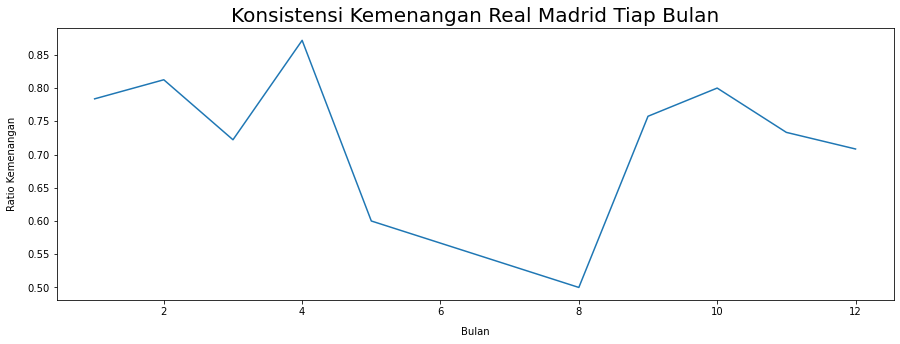

In [28]:
plt.plot(konsistensi_performa.index,konsistensi_performa['Ratio_Menang'])
plt.gcf().set_size_inches(15, 5)
plt.xlabel('Bulan', labelpad=10)
plt.ylabel('Ratio Kemenangan',labelpad=10)
plt.title('Konsistensi Kemenangan Real Madrid Tiap Bulan', fontsize=20)
plt.show()

Umumnya Real Madrid memiliki performa yang cukup stabil sepanjang musim dengan rasio kemenangan sekitar 70% hingga 85%. Namun, terlihat terjadi penurunan performa Real Madrid pada bulan ke 5 (Mei) dan bulan ke 8 (Agustus). Bulan-bulan tersebut merupakan akhir sebuah musim dan awal musim bagi kompetisi La Liga. Penurunan performa ini mungkin dapat dijelaskan bahwa:

1. Ketika bulan Mei, umumnya La Liga sudah memiliki juaranya sehingga hasil pertandingan menjadi tidak berarti dalam kaitannya dengan perebutan gelar juara. Oleh karena itu, tim Real Madrid akan lebih sering melakukan rotasi pemain. Hal ini juga didukung dengan fakta bahwa pada turnamen lain seperti Copa del Rey dan Liga Champions pada bulan tersebut sedang berada dalam babak yang krusial (penentuan juara). Sehingga masuk akal bila Real Madrid lebih memprioritaskan turnamen tersebut daripada La Liga. Walaupun pada musim tertentu, pemenang La Liga ditentukan hingga akhir musim

2. Ketika bulan Agustus, bulan ini merupakan awal musim. Biasanya diawal musim, tim-tim masih melakukan adaptasi serta performa pemain yang belum 100%. Apabila suatu tim tidak dapat memanfaatkan pra musim dengan baik maka sangat mungkin bahwa hasil yang diperoleh pun kurnag maksimal karena proses adaptasi pemain dan taktik baru yang belum sempurna.

## Kesimpulan

Beberapa kesimpulan dapat diambil dari analisis ini:
1. Real Madrid memiliki *winning rate* yang tinggi pada rentang musim tersebut yaitu 75%
2. Projek Galacticos (Pembelian pemain bintang dalam jumlah banyak) pada musim 2009/2010 memberikan efek yang signifikan dengan kenaikan performa tim baik dari segi hasil maupun gol.
3. Real Madrid paling sering kalah melawan Barcelona dengan total 10 kali kekalahan
4. Real Madrid umumnya akan memiliki performa yang lebih baik pada saat bermain dalam posisi kandang baik dalam segi hasil maupun gol
5. Real Madrid merupakan tim yang cukup konsisten sepanjang musim.

# Penutup

Terimakasih telah membaca analisis ini. Penulis sadar bahwa masih banyak kekurangan dalam analisis ini dan dapat dikembangkan lebih baik lagi. Penulis juga sadar bahwa penulis masih pemula dalam hal analisis data dan masih perlu peningkatan kemampuan.

Analisis ini dibuat oleh: Muhammad Rizaldi Yani <br>
Kontak: rizaldiyani8@gmail.com